In [1]:
!pip install -q pytorch_lightning
!pip install -q wandb

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path
import pytorch_lightning as pl
import os
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

# Functions

In [3]:
def plot_fake_real_images(fake_tensor, real_img, save=False):

    img1 = F.to_pil_image(fake_tensor.squeeze(0).cpu())

    if save:
        img1.save("output.jpg")
        
    plt.imshow(img1)
    plt.axis("off")
    plt.show()

    plt.imshow(real_img)
    plt.axis("off")
    plt.show()

In [4]:
def get_n_image_path(data_path, n):
    image_paths = sorted(data_path.glob("*.jpg"))
    return image_paths[n]

In [5]:
def colorize_grey_image(grey_img, checkpoint_path):

    # Transform
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

    # model
    model = ColorizationGAN.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()

    # colorize
    img_tensor = transform(grey_img)
    img_gray = img_tensor.expand(3, -1, -1).unsqueeze(0)

    with torch.no_grad():
        fake_color = model(img_gray.to(model.device))
        fake_color = (fake_color + 1) / 2
        fake_color = fake_color.clamp(0, 1)

    # resize
    original_size = grey_img.size
    fake_color_resized = F.resize(fake_color.squeeze(0), size=original_size[::-1])

    return fake_color_resized

In [6]:
def generate_image_n(checkpoint_path, datapath, n):

    img_path = get_n_image_path(datapath, n)
    img_rgb = Image.open(img_path).convert("RGB")

    grey_img = Image.open(img_path).convert("L")
    fake_color = colorize_grey_image(grey_img, checkpoint_path)

    plot_fake_real_images(fake_color, img_rgb, save=False)

## Dataset

In [7]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.image_paths = list(self.root_dir.glob("*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        color_path = self.image_paths[idx]

        # RGB-Bild laden
        color_image = Image.open(color_path).convert("RGB")

        # Graubild erzeugen
        gray_image = color_image.convert("L")

        if self.transform:
            gray_image = self.transform(gray_image)
            color_image = self.transform(color_image)

        # Graubild zu 3 Kanälen duplizieren
        gray_image = gray_image.expand(3, -1, -1)

        filename = color_path.stem

        return gray_image, color_image, filename

## Generater

In [8]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )

        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )

        self.down1 = down_block(3, 64)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)

        self.up1 = up_block(512, 256)
        self.up2 = up_block(512, 128)
        self.up3 = up_block(256, 64)
        self.up4 = nn.ConvTranspose2d(128, 3, 4, 2, 1)  # Output RGB

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(d4)
        u1 = torch.cat([u1, d3], dim=1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)
        output = torch.tanh(self.up4(u3))
        return output

## Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1),  # (gray + color)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, gray, color):
        x = torch.cat([gray, color], dim=1)
        return self.model(x)

# Logger

In [10]:
wandb_logger = WandbLogger(
    project='CVAI',
    entity="michael-christen-hochschule-luzern",
    name='GAN_run2')

# Lightning Class

In [11]:
class ColorizationGAN(pl.LightningModule):
    def __init__(self, lambda_l1=100, lr_generator=2e-4, lr_discriminator=1e-4, b1_generator=0.5, b2_generator=0.999,
                 b1_discriminator=0.5, b2_discriminator=0.999):
        super().__init__()
        self.automatic_optimization = False
        self.save_hyperparameters()
        
        self.generator = UNetGenerator()
        self.discriminator = Discriminator()

        self.criterion_GAN = nn.BCEWithLogitsLoss()
        self.criterion_L1 = nn.L1Loss()

    def forward(self, gray_image):
        return self.generator(gray_image)

    def configure_optimizers(self):
        opt_G = torch.optim.Adam(
            self.generator.parameters(),
            lr=self.hparams.lr_generator,
            betas=(self.hparams.b1_generator, self.hparams.b2_generator))
        
        opt_D = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.hparams.lr_discriminator,
            betas=(self.hparams.b1_discriminator, self.hparams.b2_discriminator))

        return [opt_G, opt_D], []

    def training_step(self, batch, batch_idx):
        gray, real_color, _ = batch
        fake_color = self.generator(gray)
    
        # GAN optimizers
        opt_g, opt_d = self.optimizers()
    
        # === Discriminator step ===
        # real
        pred_real = self.discriminator(gray, real_color)
        target_real = torch.ones_like(pred_real)
        loss_D_real = self.criterion_GAN(pred_real, target_real)
    
        # fake
        pred_fake = self.discriminator(gray, fake_color.detach())
        target_fake = torch.zeros_like(pred_fake)
        loss_D_fake = self.criterion_GAN(pred_fake, target_fake)
    
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        opt_d.zero_grad()
        self.manual_backward(loss_D)
        opt_d.step()
        self.log("train/loss_D", loss_D, prog_bar=True)
    
        # === Generator step ===
        pred_fake_for_G = self.discriminator(gray, fake_color)
        target_real = torch.ones_like(pred_fake_for_G)
        loss_G_GAN = self.criterion_GAN(pred_fake_for_G, target_real)
        loss_G_L1 = self.criterion_L1(fake_color, real_color)
        loss_G = loss_G_GAN + self.hparams.lambda_l1 * loss_G_L1
    
        opt_g.zero_grad()
        self.manual_backward(loss_G)
        opt_g.step()
    
        self.log("train/loss_G", loss_G, prog_bar=True)
        self.log("train/loss_G_GAN", loss_G_GAN)
        self.log("train/loss_G_L1", loss_G_L1)

    def get_checkpoint(self):
        return ModelCheckpoint(
            dirpath="checkpoints/",
            filename="colorization-epoch{epoch:02d}_run2",
            save_top_k=-1,
            every_n_epochs=1,
            verbose=True,
            save_weights_only=False
        )

    def model_fit(self, max_epochs, train_dataloader, logger):

        checkpoint = self.get_checkpoint()

        trainer = pl.Trainer(
            max_epochs=max_epochs,
            logger=logger,
            callbacks=[checkpoint]
        )

        trainer.fit(self, train_dataloader)

In [12]:
#os.environ["WANDB_API_KEY"] = 'XXX'
#wandb.login()

In [13]:
# Hyperparameter
lambda_l1 = 100
lr_generator = 2e-4
lr_discriminator = 1e-4
b1_generator = 0.5
b2_generator = 0.999
b1_discriminator = 0.5
b2_discriminator = 0.999

max_epochs = 50
batch_size = 128
datapath = Path('/exchange/cvai/colorAIzer/data/coco2017')
output_folder = Path.cwd() / "images" / "generated"

In [14]:
torch.set_float32_matmul_precision('medium')

In [15]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

dataset = ColorizationDataset(root_dir=datapath, transform=transform)

In [16]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16)

# Train from scratch

In [17]:
#model = ColorizationGAN(lambda_l1, lr_generator, lr_discriminator, b1_generator, b2_generator, b1_discriminator, b2_discriminator)
#model.model_fit(max_epochs, train_dataloader, wandb_logger)

# Train loaded model

In [18]:
#model = ColorizationGAN.load_from_checkpoint('checkpoints/colorization-epochepoch=49.ckpt')
#model.model_fit(max_epochs, train_dataloader, wandb_logger)

# Eval

In [19]:
def print_checkpoints():
    checkpoint_dir = Path("checkpoints")
    checkpoints = list(checkpoint_dir.glob("*.ckpt"))

    for ckpt in checkpoints:
        print(ckpt)
print_checkpoints()

checkpoints/colorization-epochepoch=00.ckpt
checkpoints/colorization-epochepoch=00-v1.ckpt
checkpoints/colorization-epochepoch=01.ckpt
checkpoints/colorization-epochepoch=02.ckpt
checkpoints/colorization-epochepoch=03.ckpt
checkpoints/colorization-epochepoch=04.ckpt
checkpoints/colorization-epochepoch=05.ckpt
checkpoints/colorization-epochepoch=06.ckpt
checkpoints/colorization-epochepoch=07.ckpt
checkpoints/colorization-epochepoch=08.ckpt
checkpoints/colorization-epochepoch=09.ckpt
checkpoints/colorization-epochepoch=10.ckpt
checkpoints/colorization-epochepoch=11.ckpt
checkpoints/colorization-epochepoch=12.ckpt
checkpoints/colorization-epochepoch=13.ckpt
checkpoints/colorization-epochepoch=14.ckpt
checkpoints/colorization-epochepoch=15.ckpt
checkpoints/colorization-epochepoch=16.ckpt
checkpoints/colorization-epochepoch=17.ckpt
checkpoints/colorization-epochepoch=18.ckpt
checkpoints/colorization-epochepoch=19.ckpt
checkpoints/colorization-epochepoch=20.ckpt
checkpoints/colorization-epoc

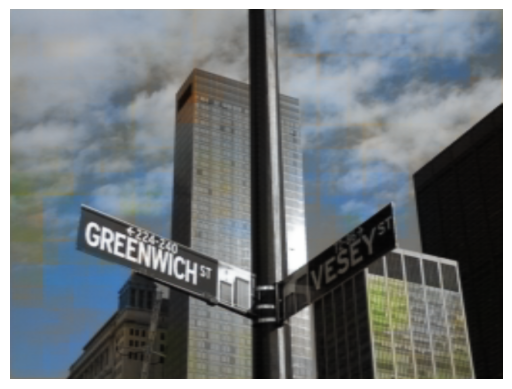

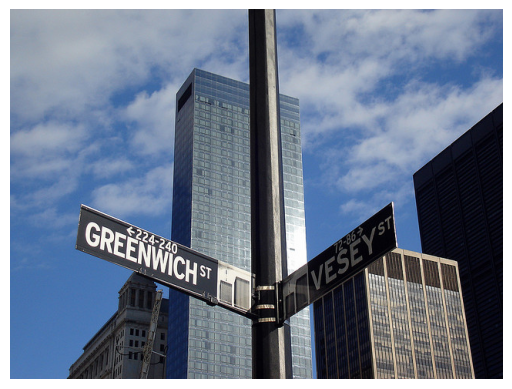

In [20]:
generate_image_n('checkpoints/colorization-epochepoch=49_run2.ckpt', datapath, 42)

# Test

In [21]:
folder = Path("/exchange/cvai/colorAIzer/data/testpics")
for file in folder.iterdir():
    if file.is_file():
        print(file.resolve()) 

/exchange/cvai/colorAIzer/data/testpics/wasserfall.jpg
/exchange/cvai/colorAIzer/data/testpics/slawek-k-FeWQVooUhDM-unsplash.jpg
/exchange/cvai/colorAIzer/data/testpics/edoardo-busti-2QwMsZ1TIdI-unsplash.jpg
/exchange/cvai/colorAIzer/data/testpics/daniel-barnes-RKdLlTyjm5g-unsplash.jpg
/exchange/cvai/colorAIzer/data/testpics/jannik-mY2ZHBU6GRk-unsplash.jpg
/exchange/cvai/colorAIzer/data/testpics/nick-fewings-9Cdt0dwvb-s-unsplash.jpg
/exchange/cvai/colorAIzer/data/testpics/gr-stocks-Iq9SaJezkOE-unsplash.jpg
/exchange/cvai/colorAIzer/data/testpics/esma-q-MCC1g6Ziw-unsplash.jpg
/exchange/cvai/colorAIzer/data/testpics/bruno-cervera-tI7L0UvgJXA-unsplash.jpg


In [22]:
def colorize_save_img(img_path, model_ckpt):
    filename = img_path.name
    grey_img = Image.open(img_path).convert("L")
    rgb = colorize_grey_image(grey_img, model_ckpt).cpu()
    rgb_np = rgb.permute(1, 2, 0).numpy()
    
    plt.imsave(filename, rgb_np)
    
    plt.imshow(rgb_np)
    plt.axis("off")
    plt.show()

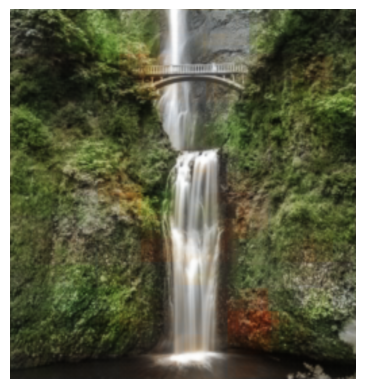

In [23]:
model_ckpt = 'checkpoints/colorization-epochepoch=49_run2.ckpt'
img_path = Path('/exchange/cvai/colorAIzer/data/testpics/wasserfall.jpg')
colorize_save_img(img_path, model_ckpt)